In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('passwords.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  100000 non-null  object
 1   strength  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


Рассмотрим распределение классов надежности в фрейме данных.

,password,percent
strength,,
0,13428,13.428
1,74278,74.278
2,12294,12.294


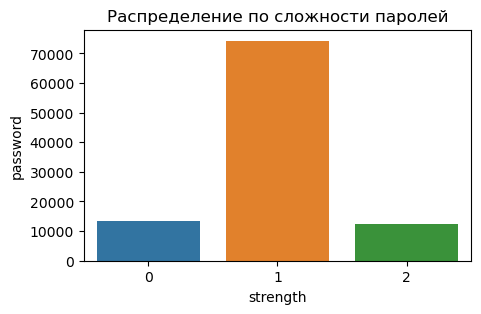

In [3]:
pt = df.pivot_table(index='strength', values='password', aggfunc='count')
pt['percent'] = (pt['password'] / pt['password'].sum()) * 100
display(pt)

fig = plt.figure(figsize=(5,3))
fig = plt.title('Распределение по сложности паролей')
fig = sns.barplot(pt, x=pt.index, y=pt.password)
plt.show()

В выборке имеется явный дисбаланс классов. Необходимо будет иметь это ввиду при обучении модели.

In [4]:
def tras(dt: pd.DataFrame):

  dt['len_str'] = dt['password'].str.len()
  dt['small_lat'] = dt['password'].str.count('[a-z]')
  dt['later_lat'] = dt['password'].str.count('[A-Z]')
  dt['digit'] = dt['password'].str.count('[0-9]')
  dt['spec_simb'] = dt['password'].str.count('[^0-9a-zA-Z]')
  dt['star_simb'] = dt['password'].str.match('[^0-9a-zA-Z]')
  dt['start_digit'] = dt['password'].str.match('[0-9]')
  dt['start_sLat'] = dt['password'].str.match('[a-z]')
  dt['start_bLat'] = dt['password'].str.match('[A-Z]')
  return dt


In [5]:
df = tras(df)
df.head()

,password,strength,len_str,small_lat,later_lat,digit,spec_simb,star_simb,start_digit,start_sLat,start_bLat
0,yrtzuab476,1,10,7,0,3,0,False,False,True,False
1,yEdnN9jc1NgzkkBP,2,16,9,5,2,0,False,False,True,False
2,sarita99,1,8,6,0,2,0,False,False,True,False
3,Suramerica2015,2,14,9,1,4,0,False,False,False,True
4,PPRbMvDIxMQ19TMo,2,16,4,10,2,0,False,False,False,True


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


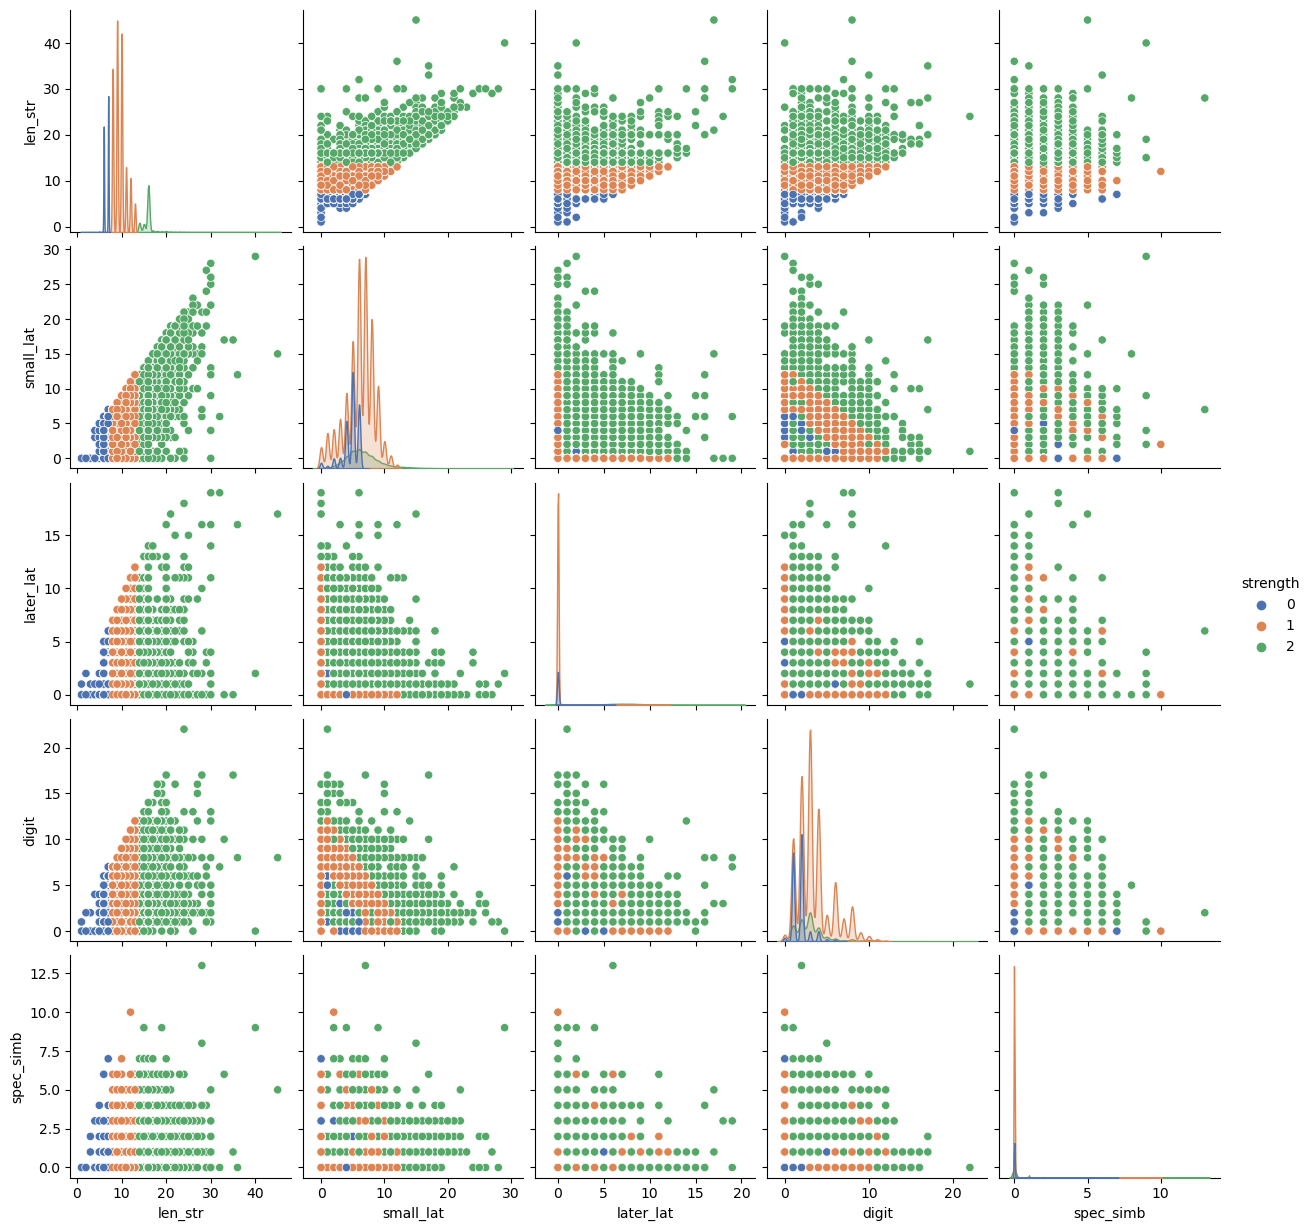

In [6]:
list_col_1 = ['len_str', 'small_lat', 'later_lat',
            'digit', 'spec_simb', 'strength']

sns.pairplot(df[list_col_1], hue='strength', palette='deep')


По графикам видно, что большое влияние на тип надежности пароля оказывает его длина, на графиках видна четкая разбивка классов по числу символов в пароле.

Отбалансируем классы в выборке и начнем обучение моделей.

In [7]:
da = df.query('strength != 1').sample(frac=0.8, random_state=123)
df = pd.concat([da] + [df])
df = shuffle(df, random_state=123)

In [8]:
list_f = ['len_str', 'small_lat', 'later_lat',
            'digit', 'spec_simb','star_simb',
          'start_sLat', 'start_bLat', 'start_digit']

features = df[list_f]
target = df['strength']

f_train, f_test, t_train, t_test = train_test_split(features, target, test_size=0.3, random_state=123)

In [9]:
tree_mod = DecisionTreeClassifier(random_state=123)
forest_mod = RandomForestClassifier(random_state=123)
log_mod = LogisticRegression(random_state=123)

step_tree = [('classifier', tree_mod)]
step_forest = [('classifier', forest_mod)]
step_log = [('classifier', log_mod)]

pr_tree = {
   'classifier__criterion': ['gini', 'entropy'],
   'classifier__max_depth': [i for i in range(1,16,2)]
}
pr_forest = {
    'classifier__max_depth': [i for i in range(4,20,4)],
    'classifier__n_estimators': [100, 200],
}
pr_log = {
    'classifier__solver': ['newton-cg', 'liblinear', 'sag'],
    'classifier__C': [0.5, 0.8, 1]
}

In [10]:
pipe = Pipeline(step_tree)
tree_gs = GridSearchCV(
    estimator=pipe, scoring='accuracy',
    param_grid=pr_tree, cv=3,
    n_jobs=-1, verbose=True).fit(f_train, t_train)

print(tree_gs.best_score_)
print(tree_gs.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
1.0
{'classifier__criterion': 'gini', 'classifier__max_depth': 3}


In [11]:
pipe = Pipeline(step_forest)
forest_gs = GridSearchCV(
    estimator=pipe, scoring='accuracy',
    param_grid=pr_forest, cv=3,
    n_jobs=-1, verbose=True).fit(f_train, t_train)

print(forest_gs.best_score_)
print(forest_gs.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
1.0
{'classifier__max_depth': 4, 'classifier__n_estimators': 100}


In [12]:
pipe = Pipeline(step_log)
log_gs = GridSearchCV(
    estimator=pipe, scoring='accuracy',
    param_grid=pr_log, cv=3,
    n_jobs=-1, verbose=True).fit(f_train, t_train)

print(log_gs.best_params_)
print(log_gs.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'classifier__C': 0.5, 'classifier__solver': 'newton-cg'}
1.0


In [13]:
model = CatBoostClassifier(verbose=False)
model.fit(f_train, t_train)
predict = model.predict(f_test)
print('Acc:', accuracy_score(t_test, predict))

Acc: 1.0


Все модели выдали 100% угадывание класса по тем параметрам, которые мы сгенерировали. Поэтому придется выбирать итогову модель не опираясь на тестовые данные. Тут выбор остановим на RandomForest. По нескольким причинам:

 - модель решающего дерева лучше подходит для решения задачи классификации с большим количеством классов, чем 2;
 - именно RandomForest, по сравнению с просто DecisiunFree, позволит уменьшить вероятность ошибки за счет использования ансамбля.

In [14]:
df_v = pd.read_csv('passwords_custom_valid.csv')

In [15]:
df_v = tras(df_v)
df_v.head()

,password,strength,len_str,small_lat,later_lat,digit,spec_simb,star_simb,start_digit,start_sLat,start_bLat
0,nc5KDe,0,6,3,2,1,0,False,False,True,False
1,64vnvl,0,6,4,0,2,0,False,True,False,False
2,8snUHD,0,6,2,3,1,0,False,True,False,False
3,E3OWe!,0,6,1,3,1,1,False,False,False,True
4,GaC?Du,0,6,2,3,0,1,False,False,False,True


In [16]:
features_v = df_v[list_f]
target_v = df_v['strength']

In [17]:
model_1 = RandomForestClassifier(random_state=123, max_depth=4, n_estimators=100)
model_1.fit(f_train, t_train)
predict = model_1.predict(features_v)
print('Acc', accuracy_score(target_v, predict))

Acc 0.8571428571428571


Результат получен. Посмотрим что получилось по точности предсказаний в разрезе разных классов.

In [18]:
res = pd.DataFrame(target_v)
res['predict'] = predict
res['itis'] = res['strength'] == res['predict']

In [19]:
r_pt = res.pivot_table(index='strength', values='itis', aggfunc=['count', 'sum'])
r_pt.columns = ['sum_cat', 'true_cat']
r_pt['result_true'] = r_pt['true_cat'] / r_pt['sum_cat']
r_pt

,sum_cat,true_cat,result_true
strength,,,
0,10,10,1.00
1,40,30,0.75
2,20,20,1.00


И теперь убедимся, что модель адекватна - точность её предсказания выше точности наивной модели.

In [20]:
model = DummyClassifier(random_state=123)
model.fit(f_train, t_train)
predict = model.predict(features_v)
print('Acc', accuracy_score(target_v, predict))

Acc 0.5714285714285714


Выбранная модель адекватна.